In [1]:
import pandas as pd
import numpy as np

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon

# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


# from matplotlib import pyplot as plt
# plt.plot(emissions_control_rate[0, :])
# plt.title("Emissions Control Rate")
# plt.xlabel("Time")
# plt.ylabel("Emissions Control")
# plt.show()

from src.model import JUSTICE
from src.util.enumerations import *

# Instantiate the model
scenarios = 3
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        enable_damage_function=False,
        enable_abatement=False,
        # climate_ensembles=570, # This is to select a specific climate ensemble
    )

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [68]:
fixed_savings_rate = model.economy.get_fixed_savings_rate(time_horizon.model_time_horizon)

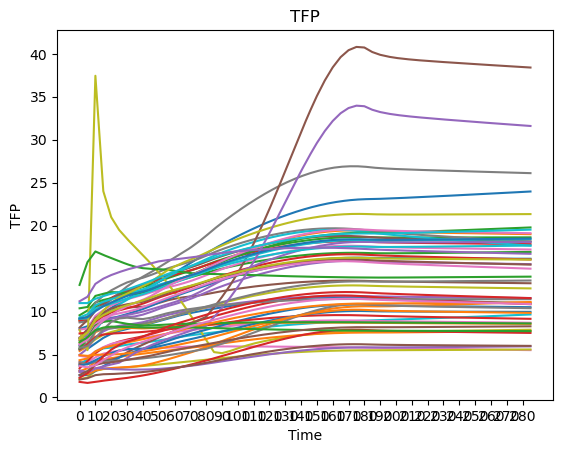

In [15]:
tfp = model.economy.tfp 

#Plot TFP
from matplotlib import pyplot as plt

# tfp is of shape (57, 286) where 57 are the regions and 286 are the timesteps
# Plot the time series of TFP for all regions
for i in range(len(data_loader.REGION_LIST)):
    plt.plot(tfp[i, :])

# Add x-axis ticks every 10 units
plt.xticks(range(0, len(time_horizon.model_time_horizon), 10))
plt.title("TFP")
plt.xlabel("Time")
plt.ylabel("TFP")
plt.show()


# Find the maximum TFP region in timestep 10 - #18
# max_tfp = np.argmax(tfp[:, 10])
# print("Region with maximum TFP in timestep 10: ", data_loader.REGION_LIST[max_tfp])
# # Print the index of the region with maximum TFP in timestep 10
# print("Index of region with maximum TFP in timestep 10: ", max_tfp)



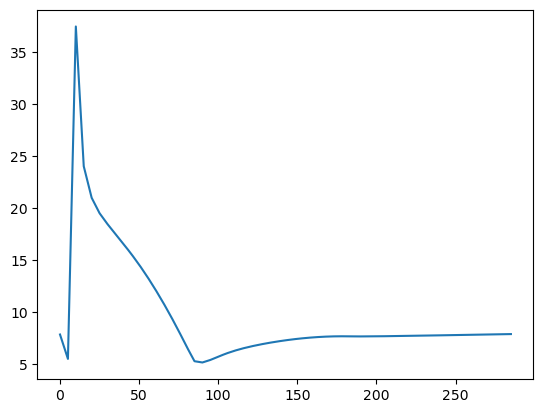

In [14]:
plt.plot(tfp[18, :])

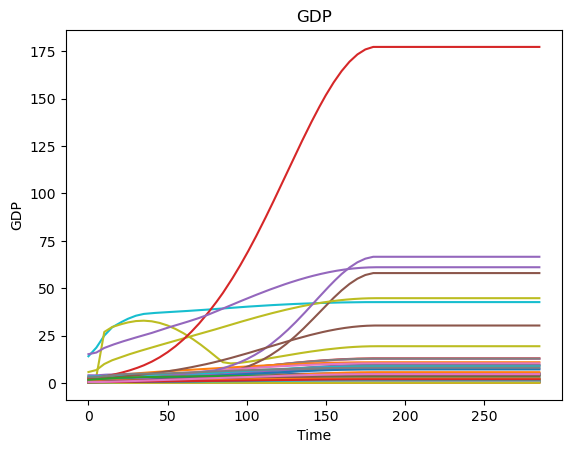

In [19]:
gdp_array = model.economy.gdp_array

#Plot GDP
from matplotlib import pyplot as plt

# gdp_array is of shape (57, 286) where 57 are the regions and 286 are the timesteps
# Plot the time series of GDP for all regions
for i in range(len(data_loader.REGION_LIST)):
    plt.plot(gdp_array[i, :])

# # Add x-axis ticks every 10 units
# plt.xticks(range(0, len(time_horizon.model_time_horizon), 10))
plt.title("GDP")
plt.xlabel("Time")
plt.ylabel("GDP")
plt.show()



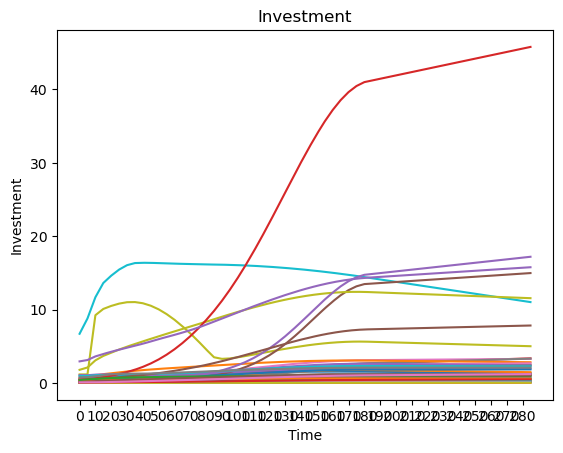

In [21]:
investment_tfp = fixed_savings_rate * gdp_array

#Plot Investment
from matplotlib import pyplot as plt

# investment_tfp is of shape (57, 286) where 57 are the regions and 286 are the timesteps
# Plot the time series of Investment for all regions
for i in range(len(data_loader.REGION_LIST)):
    plt.plot(investment_tfp[i, :])

# Add x-axis ticks every 10 units
plt.xticks(range(0, len(time_horizon.model_time_horizon), 10))
plt.title("Investment")
plt.xlabel("Time")
plt.ylabel("Investment")
plt.show()


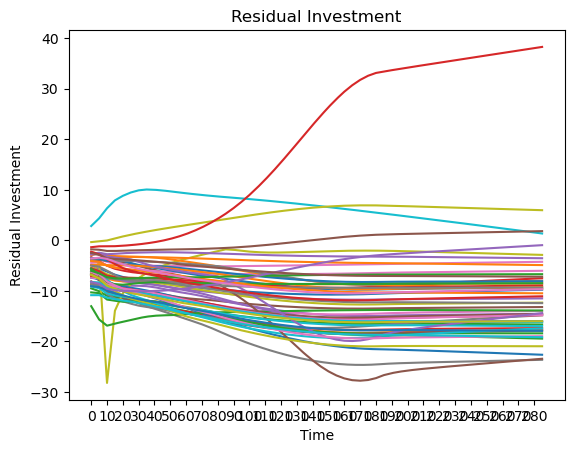

In [22]:
# residual difference between the investment and the TFP

residiual_investment_tfp = investment_tfp - tfp

#Plot Residual Investment
from matplotlib import pyplot as plt

# residiual_investment_tfp is of shape (57, 286) where 57 are the regions and 286 are the timesteps
# Plot the time series of Residual Investment for all regions
for i in range(len(data_loader.REGION_LIST)):
    plt.plot(residiual_investment_tfp[i, :])

# Add x-axis ticks every 10 units
plt.xticks(range(0, len(time_horizon.model_time_horizon), 10))
plt.title("Residual Investment")
plt.xlabel("Time")
plt.ylabel("Residual Investment")
plt.show()


In [ ]:
# Endogenous TFP
depreciation_rate_tfp = 0.01

endogenous_tfp = np.zeros((len(time_horizon.model_time_horizon)))

# Initialize the first timestep with the initial TFP value
endogenous_tfp[0] = tfp[0, 0]

# for timestep in range(1, len(time_horizon.model_time_horizon)):
#     endogenous_tfp[timestep] = endogenous_tfp[timestep - 1] * (1 - depreciation_rate_tfp) + gamma_1 * (investment_tfp[timestep])**(gamma_2)   

# endogenous_tfp[timestep] = endogenous_tfp[timestep - 1] * (1 - depreciation_rate_tfp) + gamma_1 * (investment_tfp[timestep])**(gamma_2)


In [63]:
import numpy as np
from scipy.optimize import minimize

# from scipy.optimize import differential_evolution

start_timestep = 10
tfp_region = tfp[0, start_timestep:]
investment_tfp_region = investment_tfp[0, start_timestep:]
depreciation_rate_tfp = 0.01

# Function to compute endogenous_tfp given gamma_1 and gamma_2
def compute_endogenous_tfp(gamma, investment_tfp_region, depreciation_rate_tfp):
    gamma_1, gamma_2 = gamma
    endogenous_tfp = np.zeros_like(tfp_region)
    endogenous_tfp[0] = tfp_region[0]  # Initialize the first timestep with the same value as tfp

    for timestep in range(1, len(tfp_region)):
        endogenous_tfp[timestep] = (endogenous_tfp[timestep - 1] * (1 - depreciation_rate_tfp) +
                                    gamma_1 * (investment_tfp_region[timestep])**(gamma_2))

    return endogenous_tfp

# Objective function to minimize
def objective_function(gamma):
    endogenous_tfp = compute_endogenous_tfp(gamma, investment_tfp_region, depreciation_rate_tfp)
    error = np.sum((endogenous_tfp - tfp_region) ** 2)
    return error

# Initial guesses for gamma_1 and gamma_2
initial_guess = [0.0003, 0.373]


# Perform optimization using Nelder-Mead #13.171019743567074
# result = minimize(objective_function, initial_guess, method='Nelder-Mead')

# Perform optimization using Powell # 13.171013331323081
result = minimize(objective_function, initial_guess, method='Powell')

# Print the error
print(f'Error: {result.fun}')

# Extract optimized values
gamma_1_opt, gamma_2_opt = result.x

# Print results
print(f'Optimized gamma_1: {gamma_1_opt}')
print(f'Optimized gamma_2: {gamma_2_opt}')




Error: 13.601305439111107
Optimized gamma_1: 0.11470301765742315
Optimized gamma_2: -0.18366317751454697


In [64]:
# Use optimized parameters to compute the final endogenous_tfp


endogenous_tfp_optimized = compute_endogenous_tfp([gamma_1_opt, gamma_2_opt], investment_tfp_region, depreciation_rate_tfp)

In [65]:
# Plot the original and optimized endogenous_tfp using plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_horizon.model_time_horizon, y=tfp_region, mode='lines', name='TFP'))
fig.add_trace(go.Scatter(x=time_horizon.model_time_horizon, y=endogenous_tfp_optimized, mode='lines', name='Endogenous TFP (Optimized)'))
fig.update_layout(title='Endogenous TFP vs TFP',
                  xaxis_title='Time',
                  yaxis_title='TFP')
fig.show()




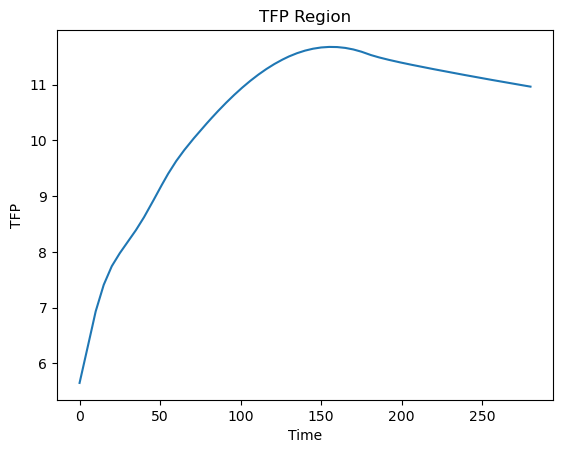

In [35]:
# PLot tfp_region 
plt.plot(tfp_region)

plt.title("TFP Region")
plt.xlabel("Time")
plt.ylabel("TFP")
plt.show()


In [71]:
import numpy as np
from scipy.optimize import minimize

# Assuming tfp and investment_tfp are already defined with shapes (57, 286)
tfp = model.economy.tfp 
investment_tfp = fixed_savings_rate * gdp_array
# and start_timestep and depreciation_rate_tfp are given

start_timestep = 10
depreciation_rate_tfp = 0.01

# Function to compute endogenous_tfp given gamma_1 and gamma_2
def compute_endogenous_tfp(gamma, investment_tfp_region, depreciation_rate_tfp):
    gamma_1, gamma_2 = gamma
    endogenous_tfp = np.zeros_like(investment_tfp_region) # Note: Corrected to investment_tfp_region shape
    endogenous_tfp[0] = tfp_region[0]  # Initialize the first timestep with the same value as tfp

    for timestep in range(1, len(tfp_region)):
        endogenous_tfp[timestep] = (endogenous_tfp[timestep - 1] * (1 - depreciation_rate_tfp) +
                                    gamma_1 * (investment_tfp_region[timestep]) ** gamma_2)

    return endogenous_tfp

# Objective function to minimize
def objective_function(gamma):
    endogenous_tfp = compute_endogenous_tfp(gamma, investment_tfp_region, depreciation_rate_tfp)
    error = np.sum((endogenous_tfp - tfp_region) ** 2)
    return error

# Initial guesses for gamma_1 and gamma_2
initial_guess = [0.0003, 0.373]

# Array to store optimized gamma parameters for all regions
optimized_gammas = np.zeros((len(data_loader.REGION_LIST), 2))  # Shape (57, 2) to store gamma_1 and gamma_2 for each region

# Loop over each region
for region_idx in range(len(data_loader.REGION_LIST)):
    tfp_region = tfp[region_idx, start_timestep:]
    investment_tfp_region = investment_tfp[region_idx, start_timestep:]
    
    # Perform optimization for the current region using Powell method
    result = minimize(objective_function, initial_guess, method='Powell')
    
    # Store the optimized gamma parameters
    optimized_gammas[region_idx, :] = result.x

    # Print the error and results for debug purposes
    print(f'Region {region_idx + 1}:')
    print(f'Error: {result.fun}')
    print(f'Optimized gamma_1: {result.x[0]}')
    print(f'Optimized gamma_2: {result.x[1]}')
    print('------')

# Print the final optimized gammas for all regions
print('Final optimized gamma parameters for all regions:')
print(optimized_gammas)

Region 1:
Error: 13.601305439207582
Optimized gamma_1: 0.11470301758262594
Optimized gamma_2: -0.18366317826305872
------
Region 2:
Error: 117.74329392623541
Optimized gamma_1: 0.20485351281431272
Optimized gamma_2: -0.01606675073103108
------
Region 3:
Error: 35.57124353894626
Optimized gamma_1: 0.16359108774515152
Optimized gamma_2: -0.12536926734322193
------
Region 4:
Error: 24.731678045842735
Optimized gamma_1: 0.16573306366666593
Optimized gamma_2: -0.14785856316339402
------
Region 5:
Error: 5.478558933547994
Optimized gamma_1: 0.05916470181433573
Optimized gamma_2: -0.28308872864946255
------
Region 6:
Error: 9.500535160145066
Optimized gamma_1: 0.08850757031156965
Optimized gamma_2: -0.18890893640733541
------
Region 7:
Error: 2.4269042000810357
Optimized gamma_1: 0.05691145029556845
Optimized gamma_2: -0.5519616782721037
------
Region 8:
Error: 350.83273977469696
Optimized gamma_1: 0.29367412468417775
Optimized gamma_2: -0.026965167742516973
------
Region 9:
Error: 33.3060840